In [2008]:
import copy
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import gmplot
import googlemaps

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2009]:
data = pd.read_csv('data/zip_code_database.csv')

In [2010]:
#find all WA state zips
WA_zips = list(data[data['state'] == 'WA']['zip'].values)

#number of WA zips
print(len(WA_zips))

733


In [2011]:
#create zips as strings too
WA_zips_strings=[]
for zipcode in WA_zips:
    WA_zips_strings.append(str(zipcode))

In [2012]:
def find_num_pages_in_a_zip(driver):
    #iterations are number of pages needed to go through on the Subway website - usually 5
    iterations = driver.find_elements_by_class_name('locatorResultsPaging')
    try:
        #cast iterations to an int
        num_iterations = int(iterations[0].text[-1])
        return num_iterations
    except:
        return 'continue'

In [2013]:
def get_total_address(address, city_state):
    adrs = address[i].text.replace('.','')
    city_state_list = city_and_state[i].text.replace(',','').split()
    sub_zip_code = city_state_list[-2][0:6]
    sub_city = city_state_list[0]
    return (adrs + ' ' + sub_city + ' ' + sub_zip_code,sub_zip_code)

In [2016]:
#scrape Subway locations from Subway.com - tried Beautiful Soup and it doesn't work
driver = webdriver.Chrome('/Users/ericnaon/Downloads/chromedriver')

#use defaultdict to put multiple locations in the same zip as a list
subway_dict = defaultdict(list)

#iterate through all zips in WA and collect subway locations
for element in WA_zips:
    driver.get("https://www.subway.com/en-US/FindAStore?zip=" + str(element))
    
    num_iterations = find_num_pages_in_a_zip(driver)
    if num_iterations == 'continue':
        continue
    
    for num in range(num_iterations):
        address = driver.find_elements_by_class_name('storeMainAddress')
        city_and_state = driver.find_elements_by_class_name('locatorAddressCityState')
        for i in range(len(address)):
            total_address, sub_zip_code = get_total_address(address, city_and_state)
            #find out if subway location is already in dictionary
            if total_address in subway_dict[sub_zip_code]:
                continue
            #append subway location if not in there
            else:
                subway_dict[sub_zip_code].append(total_address)
        #scroll down the page in order for Selenium to go to next page
        driver.execute_script("window.scrollTo(0, 500)")
        #sleep so its Selenium is able to click
        time.sleep(4)
        #find the next page div
        next_page = driver.find_elements_by_class_name('sprite-next-page-arrow')
        #click on next page button
        if next_page[0].is_displayed():
            next_page[0].click()
        time.sleep(4)
        #scroll up for on the now current page so Selenium can grab info from this current page
        driver.execute_script("window.scrollTo(0, 50)")
        time.sleep(1)
    

ElementClickInterceptedException: Message: element click intercepted: Element is not clickable at point (425, 791)
  (Session info: chrome=78.0.3904.97)


In [ ]:
#close Selenium
driver.quit()

In [237]:
#very important to not screw up the original dictionary because it took a while to build
subway_dict_copy = subway_dict.copy()

In [258]:
#some of the zips had additional numbers: eg 98123-9875. just striping everything after the '-'.
subway_locations_dict = subway_dict_copy.copy()
for key, value in subway_dict_copy.items():
    if len(key) > 5:
        subway_locations_dict.pop(key, None)
        subway_locations_dict[key[0:5]] = value

In [259]:
subway_locations_dict

{'98003': ['29017 Military Road South Federal 98003',
  '1928 S Commons C6 Federal 98003',
  '32225 Pacific Hwy South Suite 201 Federal 98003',
  '34520 16th Avenue So Federal 98003',
  '32925 First Ave South Suite M Federal 98003',
  '34815 Pacific Hwy S Suite 200 Federal 98003'],
 '98002': ['4798 Auburn Way N Suite 102 Auburn 98002',
  '1702 Auburn Way North Suite E Auburn 98002',
  '620 Auburn Way S Suite B Auburn 98002',
  '3840 A St SE Suite 101 Auburn 98002'],
 '98032': ['27020 Pacific Hwy S Suite A103 D Kent 98032',
  '1529 W Meeker St 101 Kent 98032',
  '124 North Central 105 Kent 98032',
  '23235 Pacific Coast Hwy South Kent 98032',
  '19918 68th Ave S Kent 98032'],
 '98030': ['25625 104th Avenue SE Street Kent 98030',
  '12925 SE Kent Kangley Rd Ste 104 Kent 98030'],
 '98023': ['1646 Dash Point Rd Suite C, Bldg E Federal 98023',
  '2148 SW 336th St Federal 98023'],
 '98092': ['3312 Auburn Way South Suite M Auburn 98092-',
  '1402 Lake Tapps Pkwy E Suite 108 Bldg F Auburn 9809

In [1115]:
#Selenium pulled subways outside of WA too - below gets rid of any Subway outside of WA
subway_locations_dict2 = subway_locations_dict.copy()
for key in subway_locations_dict.keys():
    if key not in WA_zips_strings:
        print(key)
        subway_locations_dict2.pop(key, None)

NameError: name 'subway_locations_dict' is not defined

In [1114]:
#curious to know the amount of Subways in WA
count = 0
for element in subway_locations_dict2.keys():
    count += len(element)
print('Number of Subways in WA:',count)

NameError: name 'subway_locations_dict2' is not defined

In [273]:
#pickle the dictionary so I don't lose it. Comment out the code so I don't accidently overwrite it

#with open('subway_dict_WA.pickle', 'wb') as handle:
    #pickle.dump(subway_locations_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1696]:
with open('data/subway_dict_WA.pickle', 'rb') as handle:
    subway_dict_WA = pickle.load(handle)

In [1698]:
#Later I realized that the addresses have Suite, builiding etc and these with these I can't
#geolocate (get lat,longitude) the subway locations. Since there are only 551 and regex sucks I cleaned manually

subway_dict_WA = {'98003': ['29017 Military Road South Federal 98003',
  '1928 S Commons C6 Federal 98003',
  '32225 Pacific Hwy South Federal 98003',
  '34520 16th Avenue So Federal 98003',
  '32925 First Ave South Federal 98003',
  '34815 Pacific Hwy S Federal 98003'],
 '98002': ['4798 Auburn Way N Auburn 98002',
  '1702 Auburn Way North Auburn 98002',
  '620 Auburn Way S Auburn 98002',
  '3840 A St SE Auburn 98002'],
 '98032': ['27020 Pacific Hwy S Kent 98032',
  '1529 W Meeker St Kent 98032',
  '124 North Central Kent 98032',
  '23235 Pacific Coast Hwy South Kent 98032',
  '19918 68th Ave S Kent 98032'],
 '98030': ['25625 104th Avenue SE Street Kent 98030',
  '12925 SE Kent Kangley Rd Kent 98030'],
 '98023': ['1646 Dash Point Rd Federal 98023',
  '2148 SW 336th St Federal 98023'],
 '98092': ['3312 Auburn Way South Auburn 98092-',
  '1402 Lake Tapps Pkwy E Auburn 98092-'],
 '98031': ['10615 SE 240th St Kent 98031',
  '8433 S 212th St Kent 98031',
  '20932 108th Avenue South Kent 98031'],
 '98047': ['420 Ellingson Road Pacific 98047'],
 '98198': ['21425 Pacific Hwy South Des 98198',
  '20619 Military Rd S SeaTac 98198'],
 '98042': ['13308 SE 240th St Kent 98042',
  '27237 172nd Ave SE Covington 98042',
  '17432 SE 270th Place Covington 98042'],
 '98422': ['4125 49th Avenue NE Tacoma 98422'],
 '98354': ['2800 Milton Way Milton 98354'],
 '98148': ['19987 1st Ave Normandy 98148',
  '15500 First Ave South Burien 98148'],
 '98188': ['18613 International Blvd SeaTac 98188',
  '16006 Pacific Hwy S SeaTac 98188',
  '305 Tukwila Parkway Tukwila 98188',
  '7100 Fun Center Way Tukwila 98188'],
 '98057': ['1250 SW 43rd St Suite E Renton 98057',
  '800 S Grady Way Renton 98057',
  '485 Rainier Ave S Renton 98057'],
 '98390': ['13704 24th Street East Sumner 98390',
  '1907 Main St Sumner 98390',
  '6617 166th Ave East Sumner 98390'],
 '98055': ['17625 108th Ave SE Renton 98055',
  '1222 Bronson Way N Renton 98055'],
 '98424': ['2639 70th Ave East Fife 98424',
  '4420 Pacific Hwy East Fife 98424',
  '4602 20th Street East Fife 98424'],
 '98058': ['17330 140th Ave SE Renton 98058',
  '15279 Maple Valley Hwy Suite 600 Renton 98058'],
 '98168': ['3725 S 144th St Tukwila 98168',
  '12805 1st Ave S Burien 98168'],
 '98371': ['1002 N Meridian Street Puyallup 98371',
  '1114 River Rd Puyallup 98371'],
 '98372': ['1501 E Main St Puyallup 98372'],
 '98038': ['27203 216th Avenue SE Maple 98038',
  '26565 Maple Valley Black Diamond Road Maple 98038',
  '22141 SE 237th Suite Maple 98038'],
 '98391': ['19579 State Route 410 East Bonney 98391',
  '20980 State Rte 410 Bonney 98391'],
 '98421': ['2615 East N Street Tacoma 98421'],
 '98373': ['3500 S Meridian Puyallup 98373',
  '4621 S Meridian Suite Puyallup 98373',
  '13414 Meridian Ave E Puyallup 98373',
  '801 S Hill Park Dr Puyallup 98373',
  '11012 Canyon Rd E Puyallup 98373'],
 '98402': ['902 Broadway Tacoma 98402', '1910 Pacific Ave Tacoma 98402'],
 '98418': ['S 101 38th St Tacoma 98418'],
 '98406': ['3001 6th Ave Tacoma 98406',
  '5961 6th Avenue Building Tacoma 98406'],
 '98597': ['17100 SR 507 SE Yelm 98597',
  '1304 Yelm Ave East Suite Yelm 98597'],
 '98405': ['1965 S Union Avenue Tacoma 98405'],
 '98004': ['1120 106th Ave NE Bellevue 98004',
  '2628 Bellevue Way NE Bellevue 98004',
  '11022 NE 8th Street Bellevue 98004',
  '300 110th Ave NE Bellevue 98004',
  '10423 Main St Bellevue 98004'],
 '98005': ['12121 Northup Way Bellevue 98005',
  '1645 140th Ave NE Bellevue 98005'],
 '98033': ['10615 NE 68th Street Kirkland 98033',
  '255 Central Way Kirkland 98033',
  '12620 NE 85th Street Kirkland 98033'],
 '98040': ['7679 SE 27th Mercer 98040',
  '8415 SE 68th St Mercer 98040'],
 '98052': ['15001 NE 24th Redmond 98052',
  '14712 NE 91st St Redmond 98052',
  '16001 Redmond Way Redmond 98052',
  '7511 166th Avenue NE Redmond 98052',
  '6536 E Sammamish Pky Redmond 98052',
  '11523 Avondale Rd Redmond 98052'],
 '98007': ['15015 Main St Bellevue 98007',
  '1410 156th Ave NE Bellevue 98007',
  '3080 - 148th Ave SE Bellevue 98007'],
 '98006': ['3720 128th Ave SE Bellevue 98006'],
 '98105': ['2756 NE 45th St Seattle 98105',
  '5401 25th Ave NE Seattle 98105',
  '4215 University Way NE Seattle 98105',
  '4336 Roosevelt Way NE Seattle 98105'],
 '98112': ['345 15th Avenue East Seattle 98112'],
 '98122': ['806 12th Avenue Seattle 98122'],
 '98144': ['2338 Rainier Ave South Seattle 98144'],
 '98034': ['11613-124th Ave NE Kirkland 98034',
  '11322 NE 124th St Kirkland 98034',
  '13501 100th Avenue NE Kirkland 98034',
  '12523 NE 144th Street Kirkland 98034',
  '14130 Juanita Drive NE Kirkland 98034'],
 '98115': ['7347 35th Avenue NE Seattle 98115',
  '8014 Lake City Way NE Seattle 98115'],
 '98104': ['951 James Street Seattle 98104',
  '1105 Madison Street Seattle 98104',
  '806 3rd Ave Seattle 98104'],
 '98102': ['2240 Eastlake Ave E Seattle 98102'],
 '98101': ['1220 Howell St Seattle 98101',
  '725 Pike Street Seattle 98101',
  '725 Pike St Seattle 98101',
  '501 Seneca Street Seattle 98101',
  '820 Stewart Street Seattle 98101',
  '1414 Third Avenue Seattle 98101',
  '1620 Fourth Ave Seattle 98101'],
 '98121': ['305 Lenora St Seattle 98121',
  '2423 Second Ave Seattle 98121',
  '2822 Western Avenue Seattle 98121'],
 '98056': ['1800 NE 44th St Renton 98056',
  '960 Harrington Ave NE Renton 98056',
  '4020 NE Fourth St Renton 98056'],
 '98134': ['2727 4th Ave S Seattle 98134'],
 '98109': ['100 Fourth Ave North Seattle 98109',
  '305 Harrison St Seattle 98109',
  '97 Denny Way Seattle 98109'],
 '98074': ['703 228th Ave NE Sammamish 98074'],
 '98075': ['3004 Issaquah Pine Lake Rd SE Sammamish 98075'],
 '98053': ['23530 NE Redmond Fall City Rd Redmond 98053',
  '22310 NE Market Place Dr Redmond 98053'],
 '98027': ['1145 NW Gilman Blvd Issaquah 98027',
  '98 Front Street Issaquah 98027'],
 '98059': ['6975 Coal Creek Parkway Newcastle 98059'],
 '98029': ['5728 E Lake Sammamish Pkwy SE Issaquah 98029'],
 '98118': ['9305A Rainier Ave S Seattle 98118'],
 '98108': ['8819 14th Ave S Seattle 98108', '5603 4th Ave S Seattle 98108'],
 '98050': ['30365 SE High Point Way Preston 98050'],
 '98022': ['235 Roosevelt Ave Enumclaw 98022'],
 '98321': ['135 Jefferson Avenue Buckley 98321'],
 '98011': ['18827 Bothell Way NE Bothell 98011',
  '18825 Campus Way NE Bothell 98011',
  '11511 NE 195th St Suite Bothell 98011'],
 '98021': ['22910 Bothell-Everett Highway Bothell 98021'],
 '98072': ['14245 NE Woodinville Duvall Rd Woodinville 98072',
  '19150 NE Woodinville Duvall Rd Woodinville 98072'],
 '98155': ['17171 Bothell Way NE Lake 98155',
  '18002 15th Avenue NE Seattle 98155',
  '20238 Ballinger Way NE Shoreline 98155'],
 '98012': ['20631 Bothell Everett Hwy Bothell 98012',
  '16310 Bothell-Everett Highway Mill 98012',
  '3414 132nd St SE Mill 98012'],
 '98043': ['22726 44th Ave W Mountlake 98043',
  '21919 66th Ave W Mountlake 98043'],
 '98125': ['12500 NE Lake City Way NE Seattle 98125',
  '14359 15th Avenue NE Seattle 98125',
  '12354 15th Ave NE Seattle 98125',
  '401 NE Northgate Way Seattle 98125',
  '327 Thornton Place NE South Seattle 98125'],
 '98036': ['2412 196th Street SW Lynnwood 98036',
  '7600 196th Ave SW Lynnwood 98036'],
 '98290': ['17424 SR 9 SE Snohomish 98290',
  '723 Ave D Snohomish 98290'],
 '98133': ['18501 Aurora Ave North Shoreline 98133',
  '12248 Aurora Ave N Seattle 98133'],
 '98026': ['23805 Highway 99 Edmonds 98026'],
 '98037': ['16911 Hwy 99 Lynnwood 98037',
  '5208 168th St SW Lynnwood 98037'],
 '98020': ['10016 Edmonds Way Edmonds 98020'],
 '98208': ['5714 134th Place SE Everett 98208',
  '10730 19th Ave SE Everett 98208',
  '305 SE Everett Mall Way Everett 98208',
  '309 East Casino Road Everett 98208'],
 '98204': ['12717 4th Avenue West Everett 98204',
  '11400 Evergreen Way Everett 98204',
  '1402 SE Everett Mall Way Everett 98204'],
 '98087': ['1233 164th St SW Lynnwood 98087',
  '2902 164th St SW STE B7 Lynnwood 98087'],
 '98275': ['11700 Mukilteo Speedway Muklilteo 98275',
  '9999 Harbour Place Mukilteo 98275'],
 '98203': ['7415 Hardeson Rd E Everett 98203',
  '5129 Evergreen Way Everett 98203'],
 '98201': ['3710 Broadway Everett 98201',
  '1620 Hewitt Ave Everett 98201',
  '2715 Hewitt Ave Everett 98201',
  '2000 W Marine View Dr Everett 98201',
  '851 N Broadway Everett 98201'],
 '98272': ['14090 Fryelands Blvd SE Monroe 98272',
  '19636 State Route 2 Monroe 98272',
  '14751 North Kelsey Street Monroe 98272',
  '19191 N Kelsey St Monroe 98272'],
 '98070': ['17408 Vashon Hwy SW Vashon 98070'],
 '98332': ['11430 51st Ave Gig 98332'],
 '98335': ['6820 Kimball Drive Gig 98335',
  '4804 Point Fosdick Dr NW Gig 98335'],
 '98166': ['594 SW 152nd Street Burien 98166'],
 '98407': ['2723 N Pearl Street Tacoma 98407'],
 '98146': ['10406 16th Ave SW Seattle 98146'],
 '98465': ['1816 S Mildred St Tacoma 98465'],
 '98409': ['4916 Center St Tacoma 98409',
  '2626 South Tacoma Way Tacoma 98409',
  '3873 South 66th Street Tacoma 98409'],
 '98366': ['1600 Woods Rd SE Port 98366',
  '3497 Bethel Rd SE Port 98366',
  '3311 Bethel Rd SE Port 98366',
  '3001 SE Mile Hill Dr Port 98366'],
 '98136': ['6515 California Ave SW Seattle 98136'],
 '98019': ['14606 Main St NE Suite Duvall 98019'],
 '98065': ['7329 Better Way SE Snoqualmie 98065'],
 '98045': ['521 South Fork Ave SW North 98045',
  '470 E North Bend Way North 98045'],
 '98294': ['US Hwy 2 & 339th Ave SE Sultan 98294'],
 '98346': ['10978 Hwy 104 Kingston 98346'],
 '98117': ['8757 Holman Rd NW Seattle 98117'],
 '98107': ['5300 15th Ave NW Seattle 98107', '4530 9th Ave NW Seattle 98107'],
 '98103': ['4301 Stone Way North Seattle 98103'],
 '98922': ['207 West 1st Street Cle Elum 98922'],
 '98360': ['215 Whitesell St Orting 98360'],
 '98375': ['16116 Meridian E Puyallup 98375',
  '16502 Meridian Ave E PUYALLUP 98375',
  '5604 176th St East Ste Puyallup 98375'],
 '98338': ['22205 Meridian Ave East Graham 98338'],
 '98404': ['402 East 56th St Tacoma 98404',
  '1407 E 72nd St Tacoma 98404'],
 '98408': ['6402 S Yakima Ave Tacoma 98408',
  '1901 S 72nd Street Tacoma 98408'],
 '98119': ['3310 3rd Ave W Seattle 98119',
  '1837 15th Ave West Seattle 98119'],
 '98106': ['6760 W Marginal Way SW Seattle 98106',
  '3829 Delridge Way SW Seattle 98106'],
 '98110': ['321 High School Road NE Bainbridge 98110'],
 '98199': ['3320 W McGraw Seattle 98199'],
 '98345': ['610 Dowell Street Keyport 98345'],
 '98311': ['1554 NE Fairgrounds Road Bremerton 98311',
  '6797 State Hwy 303 NE Bremerton 98311'],
 '98310': ['5050 State Hwy 303 NE Bremerton 98310',
  '1100 Wheaton Way Suite E Bremerton 98310'],
 '98370': ['18960 State Hwy 305 NE Poulsbo 98370',
  '19890 Viking Ave Poulsbo 98370',
  '21555 Olhava Way NW Poulsbo 98370',
  '21200 Olhava Way NW Poulsbo 98370'],
 '98383': ['2238 NW Bucklin Hill Rd Silverdale 98383',
  '10315 Silverdale Way NW Silverdale 98383'],
 '98337': ['70 Washington Ave Bremerton 98337'],
 '98315': ['2601 Ohio St Silverdale 98315'],
 '98314': ['Bldg 863 Bremerton 98314'],
 '98826': ['920 Highway 2 Leavenworth 98826'],
 '98815': ['130 Titchenal Way Cashmere 98815'],
 '98926': ['1512 Hwy 97 Ellensburg 98926',
  '1005 E University Way Ellensburg 98926',
  '1301 Canyon Rd Ellensburg 98926'],
 '98801': ['2000 N Wenatchee Ave Wenatchee 98801',
  '147 Easy Way Wenatchee 98801'],
 '98802': ['929 Mission St Wenatchee 98802', '226 Grant Rd Wenatchee 98802'],
 '98367': ['435 SW Sedgwick Road Port 98367'],
 '98258': ['1819 S Lake Stevens Road Lake 98258',
  '303 91st Ave NE Lake 98258',
  '1807 Main St Lake 98258'],
 '98312': ['Boone Rd Bldg Bremerton 98312',
  '3850 Kitsap Way Bremerton 98312',
  '4710 Werner Road Bremerton 98312'],
 '98270': ['450 State Ave Marysville 98270',
  '8713 64th Street NE Marysville 98270',
  '9214 State Ave Marysville 98270',
  '3943 116th Street NE Marysville 98270'],
 '98271': ['10600 Quilceda Blvd Tulalip 98271'],
 '98223': ['16820 Smokey Point Blvd Arlington 98223',
  '4010 172nd Street Arlington 98223',
  '7705 204th St NE Arlington 98223',
  '2211 WA-530 Arlington 98223'],
 '98252': ['703 W Stanley Street Granite 98252'],
 '98247': ['3740 Mt Baker Hwy Everson 98247',
  '102 W Main Street Everson 98247'],
 '98284': ['108 N Township Sedro 98284'],
 '98229': ['1306 Lakeway Dr Bellingham 98229'],
 '98225': ['101 South Samish Way Bellingham 98225',
  '3123 Old Fairhaven Pkwy Bellingham 98225',
  '1920 King St Bellingham 98225',
  '128 E Holly Bellingham 98225',
  '516 High St - Viking Union Bellingham 98225',
  '516 High Street Bellingham 98225',
  '3212 NW Ave Bellingham 98225'],
 '98226': ['3011 Cinema Place Bellingham 98226',
  '4152 Meridian Bellingham 98226',
  '1 Bellis Fair Pky Bellingham 98226',
  '1317 W Bakerview Rd Bellingham 98226',
  '5927 Guide Meridian Bellingham 98226'],
 '98233': ['9660 Old Highway 99 N Rd Burlington 98233',
  '325 Cascade Mall Dr Space Burlington 98233',
  '1765 S Burlington Blvd Burlington 98233'],
 '98273': ['2301 Freeway Drive Mount 98273',
  '323 E College Way Mount 98273'],
 '98274': ['2323 E Section St Mount 98274'],
 '98248': ['1678 Main Street Ferndale 98248',
  '5675-3rd Ave Ferndale 98248'],
 '98264': ['8176 Guide Meridian Lynden 98264',
  '8890 Bender Road Lynden 98264'],
 '98221': ['1518 Commercial Ave Anacortes 98221'],
 '98230': ['8115 Birch Bay Square Street Blaine 98230',
  '1733 H Street Blaine 98230'],
 '98292': ['7009 265th St NW Stanwood 98292'],
 '98277': ['32209 N State Hwy 20 Oak 98277', '1250 SW Erie Street Oak 98277'],
 '98278': ['1060 W Lexington Oak 98278'],
 '98282': ['370 NE Camano Drive Camano 98282'],
 '98368': ['1300 Water St Port 98368'],
 '98382': ['680 W Washington Sequim 98382'],
 '98433': ['Bldg 12690 - 32nd Division Dr Joint Base LewisMcChord Ft. 98433',
  'Bldg 11566 41st Division Dr Fort 98433',
  'Liggett Ave Bldg 2140 Fort 98433',
  '41st Division Dr Bldg5280 Joint Base LewisMcChord Joint 98433',
  'Bldg #2202 Liggett Avenue Joint 98433',
  '9040 Jackson Ave JB Lewis- Mc AAFES Food Ct Tacoma 98433',
  'Building 2140 Liggett Ave Joint 98433',
  'Railroad Ave Bldg 3746 3rd Brigade Shoppette Ft. 98433'],
 '98327': ['1225 Center Dr Dupont 98327',
  '1000 Station Dr Dupont 98327'],
 '98498': ['15109 Union Ave SW Tacoma 98498',
  '7701 Steilacoom Blvd SW Tacoma 98498'],
 '98516': ['9335 Martin Way Olympia 98516',
  '1401 Galaxy Dr NE Lacey 98516',
  '8205 F Martin Way Lacey 98516'],
 '98499': ['6111 Lakewood Towne Center SW Lakewood 98499',
  '7001 Bridgeport Way West Lakewood 98499',
  '7304 Lakewood Drive, W Lakewood 98499',
  '11924 Pacific Highway SW Lakewood 98499',
  '11120 Steele St S Lakewood 98499'],
 '98466': ['7317-40th Street West University 98466'],
 '98439': ['Building 545, Barnes Ave McChord 98439'],
 '98503': ['805-B College St Lacey 98503',
  '5750 Ruddell Rd SE Lacey 98503',
  '4820 Yelm Hwy SE Lacey 98503'],
 '98444': ['8415 S Hosmer St Tacoma 98444',
  '11457 Pacific Ave Tacoma 98444',
  '14125 Pacific Ave Tacoma 98444'],
 '98506': ['4055 Martin Way East Olympia 98506',
  '1908 E 4th Ave Olympia 98506'],
 '98502': ['3430 Pacific Ave SE Olympia 98502',
  '625 Black Lake Blvd Olympia 98502',
  '1001 Cooper Point Rd SW Olympia 98502',
  '6541 Sexton Dr NW Olympia 98502'],
 '98349': ['9023 Key Peninsula Hwy North Lakebay 98349'],
 '98387': ['17415 Pacific Ave South Spanaway 98387',
  '22219 Mountain Hwy E Spanaway 98387',
  '20307 Mountain Hwy East Spanaway 98387'],
 '98501': ['1050 Plum St SE Olympia 98501',
  '1023 Capitol Way S Olympia 98501',
  '408 Cleveland Ave SE Tumwater 98501',
  '5595 Capitol Blvd Tumwater 98501'],
 '98328': ['220 Center St E Eatonville 98328'],
 '98356': ['498 2nd St Morton 98356'],
 '98445': ['10909 Portland Ave Tacoma 98445'],
 '98580': ['9111 346th St Roy 98580'],
 '98331': ['490 North Forks Ave Forks 98331'],
 '98362': ['403 S Lincoln Port 98362', '3411 East Kolonels Way Port 98362'],
 '98569': ['172 W Chance a La Mer NW Ocean 98569'],
 '98550': ['2700 Simpson Ave Hoquiam 98550'],
 '98520': ['1029 East Wishkah Street Aberdeen 98520',
  '217 North Boone St Aberdeen 98520'],
 '98512': ['5729 Littlerock Road SE Tumwater 98512',
  '2430 93rd Ave Tumwater 98512',
  '5900 Little Rock Road Tumwater 98512'],
 '98563': ['211 S Main St Montesano 98563'],
 '98595': ['794 State Rt 105 Westport 98595'],
 '98584': ['2121 Olympic Hwy N Shelton 98584',
  '410 North First Street Shelton 98584'],
 '98541': ['404 W Main St Elma 98541'],
 '98557': ['227 W Simpson McCleary 98557'],
 '98532': ['1356 Rush Rd Chehalis 98532',
  '109 Interstate Ave Chehalis 98532',
  '1545 NW Louisiana Ave Chehalis 98532'],
 '98591': ['416 State Hwy 506 I-5 Toledo 98591'],
 '98589': ['698 East Sussex Ave Tenino 98589'],
 '98531': ['910 Ellsbury St Centralia 98531', '1110 View St Centralia 98531'],
 '98611': ['1163B Mt St Helens Way NE Castle 98611'],
 '98626': ['1511 Westside Highway Kelso 98626', '220 Kelso Drive Kelso 98626'],
 '98632': ['1328 Washington Way Longview 98632',
  '540 7th Ave Longview 98632',
  '3707 Ocean Beach Highway Longview 98632',
  '94 Oregon Way Longview 98632'],
 '98579': ['9920 Hwy 12 SW Rochester 98579'],
 '98908': ['210 South 72nd Avenue Suite 100 Yakima 98908',
  '6600 West Nob Hill Blvd Yakima 98908',
  '1300 N 40th Ave Yakima 98908'],
 '98902': ['2301 W Nob Hill Blvd Yakima 98902',
  '1607 West Lincoln Ave Yakima 98902',
  '508 W Nob Hill Blvd Yakima 98902'],
 '98942': ['502 South First Street Selah 98942'],
 '98901': ['123 East Yakima Road Yakima 98901',
  '4040 Terrace Heights Drive Yakima 98901'],
 '98903': ['2402 S 1st Street Yakima 98903'],
 '98648': ['220 SW 2nd Street Stevenson 98648'],
 '98951': ['631 1st Street Wapato 98951'],
 '98620': ['1100 E Broadway St Goldendale 98620'],
 '98577': ['702 Willapa Place Willapa Marketplace Raymond 98577'],
 '98631': ['1100 Pacific Ave S Long 98631'],
 '98625': ['165 N 1st Kalama 98625'],
 '98674': ['1486 Dike Access Rd Woodland 98674',
  '1999 Pacific Avenue Woodland 98674'],
 '98642': ['109 S 65th Ave Ridgefield 98642'],
 '98604': ['2312 W Main St Battle 98604',
  'SW 10th & Sw Scotten Way Battle 98604',
  '1800 SW 9th Ave Battle 98604'],
 '98686': ['13009 NE Hwy 99 Vancouver 98686'],
 '98606': ['SR 503 and NE 119th Avenue Brush 98606'],
 '98682': ['13620 NE 84th St Vancouver 98682',
  '6700 NE 162nd Ave Vancouver 98682',
  '14505 NE Fourth Plain Blvd Vancouver 98682',
  '11409 NE 28th St Vancouver 98682'],
 '98665': ['8720 NE Centre Pointe Dr Vancouver 98665',
  '9000 NE Hwy 99 Vancouver 98665',
  '8902 NE 5th Ave Vancouver 98665',
  '6525 NE Highway 99 Vancouver 98665'],
 '98662': ['5620 NE Gher Rd Vancouver 98662',
  '8700 NE Vancouver Mall Dr Vancouver 98662'],
 '98684': ['1900 NE 162nd Ave Vancouver 98684',
  '14300 NE 18 Ave Vancouver 98684',
  '13521 S E 3rd Way Vancouver 98684'],
 '98661': ['6715 NE 63rd St Vancouver 98661',
  '2265 NE Andresen Rd Vancouver 98661',
  '5000 East 4th Plain Blvd Vancouver 98661',
  '2800 East 4th Plain Blvd Vancouver 98661'],
 '98683': ['322 SE 192nd Avenue Vancouver 98683',
  '1125 SE 163rd Place Vancouver 98683',
  '3415 SE 192nd Ave Vancouver 98683'],
 '98607': ['602 NE 3rd Ave Camas 98607'],
 '98671': ['3307 SE Evergreen Way Washougal 98671'],
 '98664': ['8084 E Mill Plain Blvd Vancouver 98664',
  '221E NE 104th Avenue Vancouver 98664'],
 '98660': ['406 W 8th St Vancouver 98660'],
 '98948': ['425 S Elm St Toppenish 98948'],
 '98944': ['2675 East Lincoln Avenue Sunnyside 98944',
  '2810 East Lincoln Road Sunnyside 98944'],
 '98930': ['1005 Wallace Way Grandview 98930'],
 '99350': ['210 Merlot Prosser 99350'],
 '99320': ['515 9th Street Benton 99320'],
 '99349': ['E 76 Government Way Mattawa 99349'],
 '99353': ['4033 W Van Giesen West 99353'],
 '99352': ['2801 Duportail St Richland 99352',
  '2588 Queensgate Drive Richland 99352',
  '1323 Lee Blvd Richland 99352',
  '93 Gage Blvd Richland 99352',
  '1824 George Washington Way Richland 99352'],
 '99338': ['12231 W Clearwater, I-82 Kennewick 99338'],
 '99336': ['7504 W Clearwater Ave Kennewick 99336',
  '6607 West Canal Drive Kennewick 99336',
  '2624 W Kennewick Ave Kennewick 99336',
  '104 S Washington Kennewick 99336'],
 '99337': ['2604 South Tweedt Court Kennewick 99337',
  '2720 S Quillan Street Kennewick 99337'],
 '99301': ['4820 No Road 68 Pasco 99301',
  '7235 Burden Blvd Pasco 99301',
  '2045 W Court Street Pasco 99301',
  '2215 Hillsboro Pasco 99301'],
 '98848': ['450 F St SW Quincy 98848'],
 '98824': ['400 South Frontage Road George 98824'],
 '98816': ['2208 W Woodin Ave Chelan 98816-'],
 '98823': ['303 Basin St SW Ephrata 98823', '1399 SE Blvd Ephrata 98823'],
 '99357': ['201 Royal Rd SW Royal 99357'],
 '98837': ['2707 West Broadway Moses 98837',
  '1035 North Stratford Rd Moses 98837',
  '1005 North Stratford Road Moses 98837',
  '1520 S Pioneer Way Moses 98837',
  '1725 Kittleson Road Moses 98837'],
 '98812': ['907 State Hwy 97 Brewster 98812'],
 '99344': ['531 E Main Street Othello 99344',
  '1220 South 1st Ave Othello 99344'],
 '98857': ['201 S Main Warden 98857'],
 '98840': ['205 2nd Avenue North Okanogan 98840'],
 '98841': ['910 Koala Ave Omak 98841'],
 '99326': ['641 South Columbia Ave Connell 99326'],
 '98855': ['422 S Whitcomb Ave Tonasket 98855'],
 '99122': ['621 Morgan Street Davenport 99122'],
 '99141': ['1050 W 3rd Avenue Kettle 99141'],
 '99114': ['148 Ponderosa Rd Colville 99114'],
 '99109': ['Hwy 395 & Franklin St Chewelah 99109'],
 '99169': ['102 Galbreath Way Ritzville 99169'],
 '99022': ['611 East State Route 902 Medical 99022'],
 '99026': ['5978 Highway 291 Nine 99026'],
 '99001': ['12820 West Sunset Hwy Airway 99001',
  '1221 S Hayford Rd Airway 99001'],
 '99006': ['20 J Street Deer 99006'],
 '99224': ['10506 W Aero Rd Spokane 99224',
  '3709 S Geiger Blvd Spokane 99224',
  '4100 S Cheney-Spokane Road Spokane 99224'],
 '99208': ['9023 N Indian Trail Road Spokane 99208',
  '6420 N Nevada Spokane 99208'],
 '99004': ['2732 First St Cheney 99004'],
 '99205': ['2503 W Wellesley Avenue Spokane 99205',
  '1902 West Francis Ave Spokane 99205',
  '1103 W Northwest Blvd Spokane 99205'],
 '99323': ['NE Corner 5th and Jantz Blvd Burbank 99323'],
 '99003': ['34710 N Newport Hwy Chattaroy 99003'],
 '99218': ['12310 N SR 395 Spokane 99218',
  '9212 N Colton Spokane 99218',
  '9502 N Newport Hwy Spokane 99218'],
 '99328': ['516 W Main Dayton 99328'],
 '99362': ['541 N Wilbur Ave Walla 99362'],
 '99324': ['1700 SE Meadowbrook Blvd College 99324',
  '1605 SE Meadowbrook Drive College 99324'],
 '99201': ['1422 W 3rd Ave Spokane 99201',
  '808 W Main St Spokane 99201',
  '701 W Riverside Ave Spokane 99201'],
 '99013': ['2301 West Wellesley Ave Spokane 99013'],
 '99202': ['1225 N Ruby St Spokane 99202', '3527 E Sprague Ave Spokane 99202'],
 '99203': ['2928 S Grand Blvd Spokane 99203'],
 '99207': ['1710 N Hamilton Spokane 99207',
  '5005 N Division Spokane 99207',
  '4750 N Division Spokane 99207',
  '3925 North Market Street Spokane 99207'],
 '99223': ['3014 E 29th Ave Spokane 99223',
  '3007 E 57th St Spokane 99223'],
 '99206': ['5025 E Sprague Ave Spokane 99206',
  '9219 E Sprague Ave Spokane 99206',
  '9119 E Montgomery Ave Spokane 99206',
  'N 2114 Pines Rd S Spokane 99206'],
 '99212': ['5320 E Sprague Ave Spokane 99212',
  '5615 E Trent Spokane 99212'],
 '99021': ['N 14820 Newport Hwy Mead 99021'],
 '99216': ['12801 E Sprague Avenue Spokane 99216',
  '13411 E 32 Ave Spokane 99216',
  '14700 East Indiana Spokane 99216',
  '3808 N Sullivan Rd Spokane 99216'],
 '99036': ['325 South Sullivan Spokane 99036'],
 '99016': ['18709 E Appleway Green 99016'],
 '99019': ['1336 N Liberty Lake Road Liberty 99019'],
 '99156': ['333211 Hwy 2 Newport 99156'],
 '99111': ['811 N Main Street Colfax 99111'],
 '99163': ['460 E Main St Pullman 99163',
  '1500 NE Terrell Mall Pullman 99163',
  '1690 SE Harvest Dr Pullman 99163'],
 '99403': ['306 5th Street Clarkston 99403', '808 Bridge St Clarkston 99403'],
 '98028': ['7016 NE Bothell Way Kenmore 98028'],
 '98528': ['23701 NE Highway 3 Belfair 98528'],
 '98953': ['903B Vintage Valley Parkway Zillah 98953'],
 '99037': ['15705 E Broadway Spokane 99037']}

In [1700]:
subway_locations_map = subway_dict_WA.copy()
for key in subway_dict_WA.keys():
    if key not in WA_zips_strings:
        print(key)
        subway_locations_map.pop(key, None)

In [2006]:
#number of zips with a Subway
print(len(subway_locations_map))

276


In [1825]:
#get Google API key
with open('data/google_key.txt', 'r') as file:
        key = file.read()

In [1949]:
#create a map using Google API and gmplot. Code was changed for different maps, but this is for a heat map.
geomaps = googlemaps.Client(key=key)

subway_lat_list = []
subway_lng_list = []
#iterate through subway locations for heat map of them in WA
for element in list(subway_locations_map.values():
                    
    for subway_location in element:
                    
        geocode_result = geomaps.geocode(subway_location)
        # Geocoding an address
        lat=geocode_result[0]['geometry']['location']['lat']
        lng=geocode_result[0]['geometry']['location']['lng']
        subway_lat_list.append(lat)
        subway_lng_list.append(lng)
#have the map centered aroound Seattle
gmap = gmplot.GoogleMapPlotter.from_geocode("Seattle, WA",key, zoom = 7)
gmap.heatmap(subway_lat_list,subway_lng_list ) 

gmap.draw("data/one_pager_map.html")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


In [1651]:
#with open('data/subway_lat_list', 'wb') as handle:
    #pickle.dump(subway_lat_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1652]:
#with open('data/subway_lng_list', 'wb') as handle:
    #pickle.dump(subway_lng_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1703]:
#import ZCTA to zip code converter
zip_converter = pd.read_csv('/Users/ericnaon/Downloads/zip_to_zcta_2019.csv')

In [1704]:
#change index to regular zips
zip_converter.index = zip_converter['ZIP_CODE']

In [1705]:
zip_converter

,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type
ZIP_CODE,,,,,,
501,501,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
544,544,Holtsville,NY,Post Office or large volume customer,11742,Spatial join to ZCTA
601,601,Adjuntas,PR,Zip Code Area,00601,Zip Matches ZCTA
602,602,Aguada,PR,Zip Code Area,00602,Zip Matches ZCTA
603,603,Aguadilla,PR,Zip Code Area,00603,Zip Matches ZCTA
...,...,...,...,...,...,...
96943,96943,Yap,FM,Post Office or large volume customer,No ZCTA,"territory zip, no ZCTA available"
96944,96944,Kosrae,FM,Post Office or large volume customer,No ZCTA,"territory zip, no ZCTA available"
96960,96960,Majuro,MH,Post Office or large volume customer,No ZCTA,"territory zip, no ZCTA available"


In [2007]:
#trying to see if a zip containing a Subway does not have a ZCTA zip

#iterate through all the Subways and their zip codes
for key, value in subway_dict_WA.items():
    #find the ZCTA zip for that Subway's zip
    new_key = zip_converter.loc[int(key),'ZCTA']
    if new_key != key:
        print(new_key,key)
#if anything prints, there is something that does not match.
#It does not print - Yay!

In [ ]:
#find all unique ZCTA in WA
a =zip_converter[zip_converter['STATE'] == 'WA']['ZCTA'].astype(int).unique()
#find the number of ZCTA zips in WA
print(len(a))

In [1709]:
#import business type and employee size from census
business_data = pd.read_csv('data/zbp16detail.txt')

In [1710]:
business_data

,zip,naics,est,n1_4,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000
0,501,------,2,1,0,0,1,0,0,0,0,0
1,501,81----,2,1,0,0,1,0,0,0,0,0
2,501,813///,2,1,0,0,1,0,0,0,0,0
3,501,8131//,2,1,0,0,1,0,0,0,0,0
4,501,81311/,2,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8418278,99999,813219,3,2,1,0,0,0,0,0,0,0
8418279,99999,8133//,51,34,8,3,4,1,1,0,0,0
8418280,99999,81331/,51,34,8,3,4,1,1,0,0,0
8418281,99999,813312,34,22,5,3,2,1,1,0,0,0


In [1714]:
#find all the zips with a ZCTA and group by the zip in order to find the sum of businesses
business = business_data[business_data['zip'].isin(a)].groupby('zip').sum()

In [1715]:
#number of overall businesses per zip
business['est']

zip
98001     6828
98002     5858
98003     9576
98004    17966
98005    10156
         ...  
99363      102
99371       18
99401        6
99402      198
99403     2430
Name: est, Length: 587, dtype: int64

In [1717]:
#function to rename columns
def rename_cols(columns,string):
    new_col = []
    for col in columns:
        new_col.append(string+col)
    return new_col

In [1718]:
#df will be the big dataframe
df = business_data[business_data['zip'].isin(a)].groupby('zip').sum()
df.columns = rename_cols(df.columns,'num_businesses_')

In [1719]:
b = df.index.unique()
b

Int64Index([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
            98011,
            ...
            99357, 99359, 99360, 99361, 99362, 99363, 99371, 99401, 99402,
            99403],
           dtype='int64', name='zip', length=587)

In [1721]:
#add subway count to dataframe
df['subway_count'] = pd.Series(subway_count)

In [1722]:
df.isna().sum()

num_businesses_est           0
num_businesses_n1_4          0
num_businesses_n5_9          0
num_businesses_n10_19        0
num_businesses_n20_49        0
num_businesses_n50_99        0
num_businesses_n100_249      0
num_businesses_n250_499      0
num_businesses_n500_999      0
num_businesses_n1000         0
subway_count               311
dtype: int64

In [1723]:
#if na means there are no subways - fill them with 0 
df = df.fillna(0)

In [1724]:
#limited service restaurants (like a fast food place) being added to dataframe
num_limited_service_rest_df = business_data[(business_data['naics'] == '722513') & (business_data['zip'].isin(a))].groupby('zip').sum()
num_limited_service_rest_df.columns = rename_cols(num_limited_service_rest_df.columns,'num_limited_ser_rest_')
df = df.join(num_limited_service_rest_df,how='left')

In [1725]:
df.isna().sum()

num_businesses_est                 0
num_businesses_n1_4                0
num_businesses_n5_9                0
num_businesses_n10_19              0
num_businesses_n20_49              0
num_businesses_n50_99              0
num_businesses_n100_249            0
num_businesses_n250_499            0
num_businesses_n500_999            0
num_businesses_n1000               0
subway_count                       0
num_limited_ser_rest_est         228
num_limited_ser_rest_n1_4        228
num_limited_ser_rest_n5_9        228
num_limited_ser_rest_n10_19      228
num_limited_ser_rest_n20_49      228
num_limited_ser_rest_n50_99      228
num_limited_ser_rest_n100_249    228
num_limited_ser_rest_n250_499    228
num_limited_ser_rest_n500_999    228
num_limited_ser_rest_n1000       228
dtype: int64

In [1726]:
#fill with -1 because there is no data for some zips
df = df.fillna(-1)

In [1727]:
#restaurants and employee size being added to dataframe
num_restaurants_df = business_data[(business_data['naics'] == '72251/') & (business_data['zip'].isin(a))].groupby('zip').sum()
num_restaurants_df.columns = rename_cols(num_restaurants_df.columns,'num_rest_')
df = df.join(num_restaurants_df,how='left')

In [1728]:
df

,num_businesses_est,num_businesses_n1_4,num_businesses_n5_9,num_businesses_n10_19,num_businesses_n20_49,num_businesses_n50_99,num_businesses_n100_249,num_businesses_n250_499,num_businesses_n500_999,num_businesses_n1000,...,num_rest_est,num_rest_n1_4,num_rest_n5_9,num_rest_n10_19,num_rest_n20_49,num_rest_n50_99,num_rest_n100_249,num_rest_n250_499,num_rest_n500_999,num_rest_n1000
zip,,,,,,,,,,,,,,,,,,,,,
98001,6828,3162,1230,1050,834,288,186,36,24,18,...,50.0,16.0,7.0,15.0,10.0,2.0,0.0,0.0,0.0,0.0
98002,5858,3074,1116,798,630,108,90,36,0,6,...,74.0,23.0,9.0,13.0,26.0,3.0,0.0,0.0,0.0,0.0
98003,9576,4992,1968,1242,858,336,132,36,12,0,...,157.0,51.0,30.0,29.0,34.0,11.0,2.0,0.0,0.0,0.0
98004,17966,9236,3162,2256,1764,792,498,156,66,36,...,175.0,39.0,21.0,42.0,44.0,18.0,11.0,0.0,0.0,0.0
98005,10156,5266,1938,1434,864,372,204,60,12,6,...,54.0,22.0,14.0,11.0,5.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99363,102,30,12,24,12,6,6,6,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99371,18,12,6,0,0,0,0,0,0,0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99401,6,0,6,0,0,0,0,0,0,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1729]:
df.isna().sum()

num_businesses_est                 0
num_businesses_n1_4                0
num_businesses_n5_9                0
num_businesses_n10_19              0
num_businesses_n20_49              0
num_businesses_n50_99              0
num_businesses_n100_249            0
num_businesses_n250_499            0
num_businesses_n500_999            0
num_businesses_n1000               0
subway_count                       0
num_limited_ser_rest_est           0
num_limited_ser_rest_n1_4          0
num_limited_ser_rest_n5_9          0
num_limited_ser_rest_n10_19        0
num_limited_ser_rest_n20_49        0
num_limited_ser_rest_n50_99        0
num_limited_ser_rest_n100_249      0
num_limited_ser_rest_n250_499      0
num_limited_ser_rest_n500_999      0
num_limited_ser_rest_n1000         0
num_rest_est                     139
num_rest_n1_4                    139
num_rest_n5_9                    139
num_rest_n10_19                  139
num_rest_n20_49                  139
num_rest_n50_99                  139
n

In [ ]:
#fill some zips with -1 because there isn't data for those zips
df = df.fillna(-1)

In [1730]:
pop_data = pd.read_csv('/Users/ericnaon/Downloads/ACS_17_5YR_S0101/ACS_17_5YR_S0101_with_ann.csv')

In [1732]:
#get all the columns I want so I can rename later
cols=list(pop_data.iloc[0,:].values)

In [1734]:
#renaming Age columns
for i in list(np.arange(0,85,5)):
    if i == 0:
        string = 'Total; Estimate; AGE - ' + 'Under 5 years'
        index = cols.index(string)
    elif i == 84:
        string = 'Total; Estimate; AGE - ' + str(i) +' years and over'
        index = cols.index(string)
    else:
        string = 'Total; Estimate; AGE - ' + str(i) +' to ' + str(i+4) + ' years'
        index = cols.index(string)
    series = pd.Series(pop_data.iloc[:,index].values,index = pop_data['GEO.id2']).iloc[1:]
    series.index = series.index.astype(int)
    df[string] = series

In [1735]:
df

,num_businesses_est,num_businesses_n1_4,num_businesses_n5_9,num_businesses_n10_19,num_businesses_n20_49,num_businesses_n50_99,num_businesses_n100_249,num_businesses_n250_499,num_businesses_n500_999,num_businesses_n1000,...,Total; Estimate; AGE - 35 to 39 years,Total; Estimate; AGE - 40 to 44 years,Total; Estimate; AGE - 45 to 49 years,Total; Estimate; AGE - 50 to 54 years,Total; Estimate; AGE - 55 to 59 years,Total; Estimate; AGE - 60 to 64 years,Total; Estimate; AGE - 65 to 69 years,Total; Estimate; AGE - 70 to 74 years,Total; Estimate; AGE - 75 to 79 years,Total; Estimate; AGE - 80 to 84 years
zip,,,,,,,,,,,,,,,,,,,,,
98001,6828,3162,1230,1050,834,288,186,36,24,18,...,1997,2214,2323,2541,2645,2206,1503,906,728,332
98002,5858,3074,1116,798,630,108,90,36,0,6,...,2625,2401,1911,2297,2552,1848,1201,981,836,517
98003,9576,4992,1968,1242,858,336,132,36,12,0,...,2534,2738,2934,3448,3114,2728,2044,1561,1274,849
98004,17966,9236,3162,2256,1764,792,498,156,66,36,...,2674,2106,2644,2384,2055,1797,1501,1013,937,741
98005,10156,5266,1938,1434,864,372,204,60,12,6,...,1684,1509,1436,1039,1323,679,699,805,531,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99363,102,30,12,24,12,6,6,6,0,6,...,0,27,32,15,0,8,0,8,0,18
99371,18,12,6,0,0,0,0,0,0,0,...,30,57,11,19,45,43,25,29,24,11
99401,6,0,6,0,0,0,0,0,0,0,...,0,0,11,27,0,35,45,17,10,0


In [1736]:
df.isna().sum()

num_businesses_est                         0
num_businesses_n1_4                        0
num_businesses_n5_9                        0
num_businesses_n10_19                      0
num_businesses_n20_49                      0
num_businesses_n50_99                      0
num_businesses_n100_249                    0
num_businesses_n250_499                    0
num_businesses_n500_999                    0
num_businesses_n1000                       0
subway_count                               0
num_limited_ser_rest_est                   0
num_limited_ser_rest_n1_4                  0
num_limited_ser_rest_n5_9                  0
num_limited_ser_rest_n10_19                0
num_limited_ser_rest_n20_49                0
num_limited_ser_rest_n50_99                0
num_limited_ser_rest_n100_249              0
num_limited_ser_rest_n250_499              0
num_limited_ser_rest_n500_999              0
num_limited_ser_rest_n1000                 0
num_rest_est                             139
num_rest_n

In [1737]:
#function to pull columns from a target dataframe and put them into my dataframe
def add_more_cols_to_df(dataframe,target_df,target_col,name_zip_col,name_new_col):
    series = pd.Series(target_df[target_col].values,index = target_df[name_zip_col]).iloc[1:]
    series.index = series.index.astype(int)
    dataframe[name_new_col] = series
    return dataframe

In [1738]:
#add population to dataframe 
df = add_more_cols_to_df(df,pop_data,'HC01_EST_VC01','GEO.id2','population')

In [1739]:
df.isna().sum()

num_businesses_est                         0
num_businesses_n1_4                        0
num_businesses_n5_9                        0
num_businesses_n10_19                      0
num_businesses_n20_49                      0
num_businesses_n50_99                      0
num_businesses_n100_249                    0
num_businesses_n250_499                    0
num_businesses_n500_999                    0
num_businesses_n1000                       0
subway_count                               0
num_limited_ser_rest_est                   0
num_limited_ser_rest_n1_4                  0
num_limited_ser_rest_n5_9                  0
num_limited_ser_rest_n10_19                0
num_limited_ser_rest_n20_49                0
num_limited_ser_rest_n50_99                0
num_limited_ser_rest_n100_249              0
num_limited_ser_rest_n250_499              0
num_limited_ser_rest_n500_999              0
num_limited_ser_rest_n1000                 0
num_rest_est                             139
num_rest_n

In [1740]:
#import income data
income_data = pd.read_csv('/Users/ericnaon/Downloads/ACS_17_5YR_S1903/ACS_17_5YR_S1903_with_ann.csv')

In [1741]:
#add median income and num_households to dataframe
df = add_more_cols_to_df(df,income_data,'HC03_EST_VC02','GEO.id2','median_income')
df = add_more_cols_to_df(df,income_data,'HC01_EST_VC02','GEO.id2','num_households')

In [1742]:
df.isna().sum()

num_businesses_est                         0
num_businesses_n1_4                        0
num_businesses_n5_9                        0
num_businesses_n10_19                      0
num_businesses_n20_49                      0
num_businesses_n50_99                      0
num_businesses_n100_249                    0
num_businesses_n250_499                    0
num_businesses_n500_999                    0
num_businesses_n1000                       0
subway_count                               0
num_limited_ser_rest_est                   0
num_limited_ser_rest_n1_4                  0
num_limited_ser_rest_n5_9                  0
num_limited_ser_rest_n10_19                0
num_limited_ser_rest_n20_49                0
num_limited_ser_rest_n50_99                0
num_limited_ser_rest_n100_249              0
num_limited_ser_rest_n250_499              0
num_limited_ser_rest_n500_999              0
num_limited_ser_rest_n1000                 0
num_rest_est                             139
num_rest_n

In [1743]:
#languages spoken data
lang_data = pd.read_csv('/Users/ericnaon/Downloads/ACS_17_5YR_S1601/ACS_17_5YR_S1601_with_ann.csv')

In [1744]:
#print this so I can 
lang_data.columns = lang_data.iloc[0,:].values
lang_data

,Id,Id2,Geography,Total; Estimate; Population 5 years and over,Total; Margin of Error; Population 5 years and over,Percent; Estimate; Population 5 years and over,Percent; Margin of Error; Population 5 years and over,"Percent of specified language speakers - Speak English only or speak English ""very well""; Estimate; Population 5 years and over","Percent of specified language speakers - Speak English only or speak English ""very well""; Margin of Error; Population 5 years and over","Percent of specified language speakers - Percent speak English only or speak English ""very well""; Estimate; Population 5 years and over",...,Percent; Estimate; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages,Percent; Margin of Error; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages,"Percent of specified language speakers - Speak English only or speak English ""very well""; Estimate; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Speak English only or speak English ""very well""; Margin of Error; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Percent speak English only or speak English ""very well""; Estimate; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Percent speak English only or speak English ""very well""; Margin of Error; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Speak English less than ""very well""; Estimate; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Speak English less than ""very well""; Margin of Error; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Percent speak English less than ""very well""; Estimate; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages","Percent of specified language speakers - Percent speak English less than ""very well""; Margin of Error; CITIZENS 18 YEARS AND OVER - All citizens 18 years old and over - Speak a language other than English - Other languages"
0,Id,Id2,Geography,Total; Estimate; Population 5 years and over,Total; Margin of Error; Population 5 years and...,Percent; Estimate; Population 5 years and over,Percent; Margin of Error; Population 5 years a...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Perc...,...,Percent; Estimate; CITIZENS 18 YEARS AND OVER ...,Percent; Margin of Error; CITIZENS 18 YEARS AN...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Perc...,Percent of specified language speakers - Perc...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Spea...,Percent of specified language speakers - Perc...,Percent of specified language speakers - Perc...
1,8600000US83501,83501,ZCTA5 83501,32821,337,(X),(X),32511,372,99.1,...,1.7,0.7,397,174,83.4,10.0,79,46,16.6,10.0
2,8600000US83822,83822,ZCTA5 83822,1769,264,(X),(X),1755,265,99.2,...,0.3,0.6,5,9,100.0,100.0,0,12,0.0,100.0
3,8600000US83824,83824,ZCTA5 83824,285,64,(X),(X),285,64,100.0,...,5.2,4.2,12,10,100.0,85.6,0,12,0.0,85.6
4,8600000US83832,83832,ZCTA5 83832,1425,122,(X),(X),1401,122,98.3,...,1.2,0.9,6,6,46.2,30.4,7,7,5

In [1746]:
df = add_more_cols_to_df(df,lang_data,'Percent; Estimate; SPEAK A LANGUAGE OTHER THAN ENGLISH - Spanish','Id2','spanish_speaking')
df = add_more_cols_to_df(df,lang_data,'Percent; Estimate; SPEAK A LANGUAGE OTHER THAN ENGLISH - Other Indo-European languages','Id2','indo_euro_speaking')
df = add_more_cols_to_df(df,lang_data,'Percent; Estimate; SPEAK A LANGUAGE OTHER THAN ENGLISH - Asian and Pacific Island languages','Id2','asian_pacific_speaking')
df = add_more_cols_to_df(df,lang_data,'Percent; Estimate; SPEAK A LANGUAGE OTHER THAN ENGLISH - Other languages','Id2','other_languages')
df = add_more_cols_to_df(df,lang_data,'Percent of specified language speakers  - Percent speak English only or speak English "very well"; Estimate; Population 5 years and over','Id2','percent_english_speaking')
df

,num_businesses_est,num_businesses_n1_4,num_businesses_n5_9,num_businesses_n10_19,num_businesses_n20_49,num_businesses_n50_99,num_businesses_n100_249,num_businesses_n250_499,num_businesses_n500_999,num_businesses_n1000,...,Total; Estimate; AGE - 75 to 79 years,Total; Estimate; AGE - 80 to 84 years,population,median_income,num_households,spanish_speaking,indo_euro_speaking,asian_pacific_speaking,other_languages,percent_english_speaking
zip,,,,,,,,,,,,,,,,,,,,,
98001,6828,3162,1230,1050,834,288,186,36,24,18,...,728,332,32789,77083,11097,8.5,11.1,8.5,0.8,88.5
98002,5858,3074,1116,798,630,108,90,36,0,6,...,836,517,34255,51086,13111,17.7,4.8,7.0,0.6,87.9
98003,9576,4992,1968,1242,858,336,132,36,12,0,...,1274,849,48065,53023,18279,15.0,6.6,12.5,3.5,82.1
98004,17966,9236,3162,2256,1764,792,498,156,66,36,...,937,741,34283,117321,16006,3.3,12.3,20.7,1.1,88.1
98005,10156,5266,1938,1434,864,372,204,60,12,6,...,531,341,18735,101134,7761,5.3,10.5,22.2,2.3,83.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99363,102,30,12,24,12,6,6,6,0,6,...,0,18,329,-,64,44.6,0.0,0.0,0.0,72.9
99371,18,12,6,0,0,0,0,0,0,0,...,24,11,453,57917,191,0.0,0.0,1.8,0.0,99.5
99401,6,0,6,0,0,0,0,0,0,0,...,10,0,237,61538,80,0.0,0.0,0.0,0.0,100.0


In [1747]:
df.isna().sum()

num_businesses_est                         0
num_businesses_n1_4                        0
num_businesses_n5_9                        0
num_businesses_n10_19                      0
num_businesses_n20_49                      0
num_businesses_n50_99                      0
num_businesses_n100_249                    0
num_businesses_n250_499                    0
num_businesses_n500_999                    0
num_businesses_n1000                       0
subway_count                               0
num_limited_ser_rest_est                   0
num_limited_ser_rest_n1_4                  0
num_limited_ser_rest_n5_9                  0
num_limited_ser_rest_n10_19                0
num_limited_ser_rest_n20_49                0
num_limited_ser_rest_n50_99                0
num_limited_ser_rest_n100_249              0
num_limited_ser_rest_n250_499              0
num_limited_ser_rest_n500_999              0
num_limited_ser_rest_n1000                 0
num_rest_est                             139
num_rest_n

In [1748]:
#there are '-' in some of the columns - code below deletes and turns into 0
for col in df.columns[-5:]:
    df[col] = df[col].apply(lambda x: '0' if x == '-' else x)

In [1749]:
#education made the model worse

#education_data = pd.read_csv('/Users/ericnaon/Downloads/ACS_17_5YR_B07009/ACS_17_5YR_B07009_with_ann.csv')

In [1750]:
#below makes model worse
#df = add_more_cols_to_df(df,education_data,'HD01_VD03','GEO.id2','less_than_hs')
#df = add_more_cols_to_df(df,education_data,'HD01_VD04','GEO.id2','hs_graduate')
#df = add_more_cols_to_df(df,education_data,'HD01_VD05','GEO.id2','some_college')
#df = add_more_cols_to_df(df,education_data,'HD01_VD06','GEO.id2','bachelors')
#df = add_more_cols_to_df(df,education_data,'HD01_VD07','GEO.id2','graduate_or_pro')
#df

In [1757]:
model = GradientBoostingRegressor(learning_rate=.01, criterion='mae',max_depth=6)

In [1765]:
df.isna().sum()

num_businesses_est                       0
num_businesses_n1_4                      0
num_businesses_n5_9                      0
num_businesses_n10_19                    0
num_businesses_n20_49                    0
num_businesses_n50_99                    0
num_businesses_n100_249                  0
num_businesses_n250_499                  0
num_businesses_n500_999                  0
num_businesses_n1000                     0
num_limited_ser_rest_est                 0
num_limited_ser_rest_n1_4                0
num_limited_ser_rest_n5_9                0
num_limited_ser_rest_n10_19              0
num_limited_ser_rest_n20_49              0
num_limited_ser_rest_n50_99              0
num_limited_ser_rest_n100_249            0
num_limited_ser_rest_n250_499            0
num_limited_ser_rest_n500_999            0
num_limited_ser_rest_n1000               0
num_rest_est                             0
num_rest_n1_4                            0
num_rest_n5_9                            0
num_rest_n1

In [1766]:
#clean median income columns

med_ints = list()
for element in list(df['median_income'].values):
    if '-' in element:
        med_ints.append(0)
    elif '+' in element:
        med_ints.append(int(element.replace('+','').replace(',','')))
    else:
        med_ints.append(int(element))

TypeError: argument of type 'numpy.float64' is not iterable

In [1760]:
df['median_income'] = med_ints

In [1769]:
for col in df.columns:
    df[col] = df[col].astype(float)

In [1770]:
#need to take out the target column so no data leakage
y = df['subway_count']
df.drop(columns='subway_count',inplace=True)

KeyError: 'subway_count'

In [1771]:
#cross validate so can get predictions for all zips
y_pred = cross_val_predict(model, df, y, cv=8)

In [1994]:
#create dataframe to be used for website
df_prediction = pd.DataFrame(index=y.index)
df_prediction.index.name = 'zip'

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [1818]:
#add predictions
df_prediction['prediction'] = y_pred

In [1819]:
#add actual
df_prediction['actual'] = y

In [1821]:
#add differene between model and actual
df_prediction['difference'] = df_prediction['prediction']-df_prediction['actual']

In [1998]:
#if predicts negative subways change those to 0
df_prediction['prediction'] = df_prediction['prediction'].replace(df_prediction[df_prediction['prediction'] < 0]['prediction'], 0)
df_prediction['difference'] = df_prediction['prediction'] - df_prediction['actual']
df_prediction

,prediction,actual,difference
zip,,,
98001,2.009090,0.0,2.009090
98002,2.581686,4.0,-1.418314
98003,2.441724,6.0,-3.558276
98004,3.569454,5.0,-1.430546
98005,0.747766,2.0,-1.252234
...,...,...,...
99363,0.342532,0.0,0.342532
99371,0.342532,0.0,0.342532
99401,0.342532,0.0,0.342532


In [1999]:
#pickle df so it can be used on website and used for later

#df_prediction.to_pickle('data/result_website.pkl')
df_prediction

,prediction,actual,difference
zip,,,
98001,2.009090,0.0,2.009090
98002,2.581686,4.0,-1.418314
98003,2.441724,6.0,-3.558276
98004,3.569454,5.0,-1.430546
98005,0.747766,2.0,-1.252234
...,...,...,...
99363,0.342532,0.0,0.342532
99371,0.342532,0.0,0.342532
99401,0.342532,0.0,0.342532


In [1975]:
#zip code with max difference - best zip to build a subway
print(prediction_zip.max())
df_prediction['difference'].idxmax()

98103

In [1879]:
#zips with a positve difference of 1 or greater
df_prediction[df_prediction['difference'] >= 1].index

Int64Index([98001, 98006, 98008, 98021, 98102, 98103, 98116, 98118, 98122,
            98126, 98158, 98178, 98296, 98374, 98662, 98685, 98801, 98932,
            99005, 99362],
           dtype='int64', name='zip')

In [1854]:
with open('data/google_key.txt', 'r') as file:
        key = file.read()

In [1954]:
#create a map of circles with positives difference of 1 or greater

gmap = gmplot.GoogleMapPlotter.from_geocode("Seattle, WA",key, zoom = 7)
geomaps = googlemaps.Client(key=key)
zip_lst = list(df_prediction[df_prediction['difference'] >= 1].index)

radius = .001
for element in zip_lst:
    geocode_result = geomaps.geocode(element)
    lat=geocode_result[0]['geometry']['location']['lat']
    lng=geocode_result[0]['geometry']['location']['lng']
    lat_list = []
    lng_list = []
    #create circles around a zip
    for theta in np.linspace(0, 2*np.pi, 50):
        lat_list.append(lat + radius * 0.67 * np.sin(theta))
        lng_list.append(lng + radius* np.cos(theta))
    gmap.plot(lat_list, lng_list,'black', edge_width=10)

    
gmap.draw("data/one_pager_map.html")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [1484]:
#find the mean absolute error over the cross validated predictions
cross_validated_score = cross_val_score(model, df, y, scoring='neg_mean_absolute_error',cv=8)

In [1485]:
#average mean absolute error
-1*np.mean(cross_validated_score)

-0.5847805709688331

In [1898]:
#finding feature importance
model.fit(df,y)

GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.01, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [1933]:
#finding top 5 features
y = model.feature_importances_[:5]
x = df.columns[np.argsort(model.feature_importances_)[:5]]
print(x)

5
Index(['num_rest_n250_499', 'num_limited_ser_rest_n100_249', 'num_rest_n1000',
       'num_limited_ser_rest_n250_499', 'num_rest_n500_999'],
      dtype='object')


In [ ]:
#renaming top 5 features for bar graph

x = ['# Restaurants w/ 240-499 Employees','# Limited Serive restaurants w/ 100-249 Employees', '# Restaurants w/ 1000+ Employees',
     '# Limited Service restaurants w/ 250-499 Employees','# Restaurants w/ 500-999 Employees']
     

5 5


Text(0.5, 1.0, '5 Top Features')

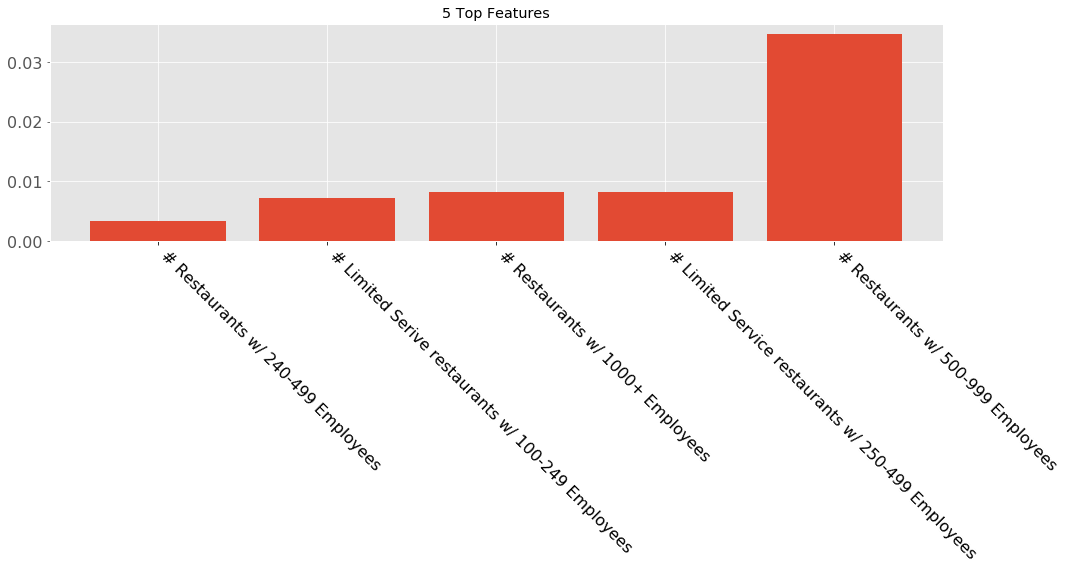

In [1939]:
#creating a bar chart of top five features
fig, ax = plt.subplots(figsize=(16, 4))

ax.bar(x, y)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='both', which='major', labelsize=16)
plt.title('5 Top Features')

In [1546]:
#checking out the top feature importances
df.columns[np.argsort(model.feature_importances_)]

Index(['num_rest_n250_499', 'num_rest_n1000', 'num_rest_n500_999',
       'num_limited_ser_rest_n500_999', 'num_limited_ser_rest_n250_499',
       'num_limited_ser_rest_n100_249', 'num_limited_ser_rest_n1000',
       'num_rest_n100_249', 'num_businesses_n1000', 'num_businesses_n500_999',
       'num_limited_ser_rest_n1_4', 'Total; Estimate; AGE - 50 to 54 years',
       'num_businesses_n250_499', 'Total; Estimate; AGE - 5 to 9 years',
       'num_rest_n1_4', 'Total; Estimate; AGE - 40 to 44 years',
       'Total; Estimate; AGE - 10 to 14 years',
       'Total; Estimate; AGE - 45 to 49 years',
       'Total; Estimate; AGE - 60 to 64 years',
       'Total; Estimate; AGE - 80 to 84 years', 'num_businesses_n50_99',
       'Total; Estimate; AGE - 15 to 19 years', 'spanish_speaking',
       'num_rest_est', 'asian_pacific_speaking', 'other_languages',
       'num_rest_n5_9', 'Total; Estimate; AGE - 65 to 69 years',
       'Total; Estimate; AGE - 30 to 34 years', 'num_businesses_est',
       '